# 训练一个分类器
目前我们已经可以定义神经网络，计算损失函数，更新网络权重。可以开始思考其他问题
## What about data？
一般，我们处理图像、文本、声音和视频数据，我们可以使用 python 标准包来载入数据到 numpy 数组里。然后使用 `torch.*Tensor`来转换数据。

* 对于图像，我们一般使用 Pillow， OpenCV包
* 对于语音，一般使用 scipy 和 librosa包
* 对于文本，Python原生的包或者 Cython包就可以载入，或者使用 NLTK 和 SpaCy

对于视觉目标，我们创建了一个包叫做 `torchvision`，这个包有通用数据集的载入器，比如ImageNet，CIFAR10，MNIST，等等。还有一些数据转换功能，比如`torchvision.datasets`和`torch.utils.data.DataLoader`

这使我们应用起来十分方便，并且避免了写许多重复的代码。

此处，我们使用 CIFAR10 数据集，它包含以下类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. 这些图片都是 3x32x32，3通道RGB图像，像素是32x32。

## 训练一个图片分类器
我们将按照以下步骤来进行:

1. 载入CIFAR10 训练与测试数据集通过 `torchvision`
2. 定义一个卷积神经网络
3. 定义一个损失函数
4. 在训练数据集上开始姿训练神经网络
5. 在测试数据集上测试训练的结果

### 1. 载入并标准化 CIFAR10 数据
使用 `torchvision`数据集，可以非常方便的载入 CIFAR10 数据集

In [3]:
%matplotlib inline

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

`torchvision`的输出是PIL图像，范围是[0,1]，我们将其转化为Tensors，并将其标准化到[-1,1].

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                       download=True, transform=transform) 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane','car','bird','cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


接下来我们演示一些训练图片

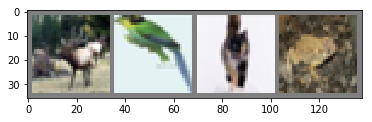

 deer  bird   cat  frog


In [16]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5 # 去标准化
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# 随机获得一些训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

### 2. 定义一个卷积神经网络
从上一节神经网络部分 copy 代码过来，将其由单通道图片改为3通道图片.

In [18]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

### 3. 定义损失函数和优化器
我们使用分类交叉熵(Classification Cross-Entropy)损失和随机梯度下降(SGD with momentum).

In [19]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 4.训练这个网络
这是事情开始变得有趣的地方，我们只需要遍历迭代器，然后将输入馈送进网络并开始优化。

In [21]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        # 清零梯度缓存 zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 打印统计数据 print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
            
print('Finished Training')
    

[1,  2000] loss: 2.203
[1,  4000] loss: 1.892
[1,  6000] loss: 1.709
[1,  8000] loss: 1.615
[1, 10000] loss: 1.549
[1, 12000] loss: 1.528
[2,  2000] loss: 1.448
[2,  4000] loss: 1.423
[2,  6000] loss: 1.388
[2,  8000] loss: 1.361
[2, 10000] loss: 1.377
[2, 12000] loss: 1.339
Finished Training


接下来保存模型

In [31]:
PATH = './model/cifar_net.pth'
torch.save(net.state_dict(), PATH)

跟多关于模型保存的内容查看 [这里](https://pytorch.org/docs/stable/notes/serialization.html)

### 5. 在测试数据集上测试网络
首先，先熟悉一下测试集里的数据

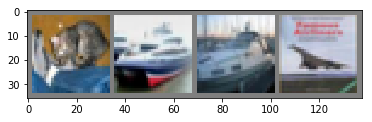

GroudTruth:    cat  ship  ship plane


In [32]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# 打印图片
imshow(torchvision.utils.make_grid(images))
print('GroudTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接下来，我们将保存的模型重载（实际上，在这个代码里，我们可以不保存，直接使用）

```python
net = Net()
net.load_state_dict(torch.load(PATH))

```

In [36]:
outputs = net(images)

输出是每一张图片对应十个值，即是十个类别中的某一个大概率，那么这十个值那个最大，我们就认为这个图像属于它对应的类别。

In [38]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                             for j in range(4)))

Predicted:    cat  ship   car  ship


我们看一下在整个测试集上，模型表现如何:

In [43]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
100 * correct / total))


Accuracy of the network on the 10000 test images: 53 %


接下来看在10类上的识别准确率

In [42]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
            
    for i in range(10):
        print("Accuracy of %5s : %2d %%" % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 47 %
Accuracy of   car : 73 %
Accuracy of  bird : 27 %
Accuracy of   cat : 40 %
Accuracy of  deer : 46 %
Accuracy of   dog : 55 %
Accuracy of  frog : 60 %
Accuracy of horse : 61 %
Accuracy of  ship : 68 %
Accuracy of truck : 51 %
